In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
class NeuralNet:
    
    
    def __init__(self, normalize = True, learning_rate = 0.01, max_iter = 30000, hidden_layer_sizes=(100,), beta=0.9, epsilon=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.beta = beta
        self.epsilon = epsilon
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        self.__compute_S(hidden_layers)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) * 0.01)
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis=1)
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
    
    
    def __compute_S(self, hidden_layers):
        self.S_dW = list()
        self.S_db = list()
        for i in range(1, self.n_layers+1):
            self.S_dW.append(np.zeros((hidden_layers[i], hidden_layers[i-1])))
            self.S_db.append(np.zeros((hidden_layers[i], 1)))
        
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            self.S_dW[i] = self.beta * self.S_dW[i] + (1 - self.beta) * np.power(dW[i], 2)
            self.S_db[i] = self.beta * self.S_db[i] + (1 - self.beta) * np.power(db[i], 2)
            W[i] = W[i] - self.learning_rate * dW[i] / (np.sqrt(self.S_dW[i]) + self.epsilon)
            b[i] = b[i] - self.learning_rate * db[i] / (np.sqrt(self.S_db[i]) + self.epsilon)

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        for i in range(self.max_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            cost_history.append(cost)
            
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
  
            if i > 1 and abs(cost-cost_history[-2]) < self.epsilon:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  

    def to_classlabel(self, z):
        return z.argmax(axis=1)

In [3]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris.data
Y = iris.target.reshape((X.shape[0], 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

print(type(y_train))
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

<class 'numpy.ndarray'>
Training set: X=(120, 4), y=(120, 1)
Test set: X=(30, 4), y=(30, 1)


In [5]:
y_train = to_categorical(y_train)
y_train.shape

(120, 3)

0-th iteration: 0.3663378655657269
1000-th iteration: 0.02217061281069724
2000-th iteration: 0.017891872455391505
3000-th iteration: 0.020552360354605004
4000-th iteration: 0.01690790510635309


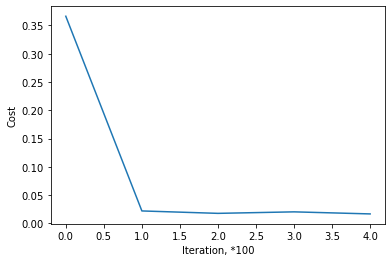

In [6]:
cls = NeuralNet(normalize = False, learning_rate = 0.1, max_iter = 30000, hidden_layer_sizes=(50,), beta=0.8, epsilon=1e-6)
cls.fit(X_train, y_train, print_cost=True)

In [7]:
print(cls.parameters)

{'W': [array([[ 3.71572931, -0.60094994, -5.43669008, -6.18588849],
       [ 2.91919669,  0.45746476, -4.81335164, -6.53470404],
       [ 3.59199356,  2.79075548, -6.25496111, -6.49480164],
       [ 2.82391608,  1.53162902, -5.38977768, -6.83218664],
       [ 5.19129579, -2.35046989, -5.97154814, -4.17748912],
       [ 4.85348951, -2.31041622, -5.78822082, -4.40752807],
       [ 4.89903136, -2.18901829, -5.74664959, -4.30733771],
       [ 4.24328116, -2.00156313, -4.88895344, -5.24313145],
       [ 4.45227839, -2.08034171, -5.54515564, -4.69298345],
       [ 1.19017736,  4.15125496, -4.88648374, -6.74482012],
       [ 4.82080536, -2.29552992, -5.82842963, -4.51199354],
       [-0.76325275, -9.06894763,  5.60818456,  3.98416373],
       [ 3.6816567 , -0.69502525, -5.28265103, -6.18111833],
       [ 2.90619926,  1.50257264, -5.46733218, -6.83766059],
       [ 4.81151847, -2.29263835, -5.79804624, -4.36931814],
       [ 1.96516386,  3.56378617, -5.42449236, -6.99014969],
       [ 2.514356

In [8]:
Y_prob = cls.predict_proba(X_test)
Y_prob

array([[5.94808528e-009, 9.99998534e-001, 1.46049342e-006],
       [2.44157028e-010, 1.00000000e+000, 2.62598775e-018],
       [5.48162222e-036, 1.91968529e-011, 1.00000000e+000],
       [1.44014949e-011, 2.09883690e-002, 9.79011631e-001],
       [9.99999991e-001, 8.62833184e-009, 2.16498599e-242],
       [6.10370814e-017, 1.00000000e+000, 1.38975782e-093],
       [9.99999991e-001, 8.65109463e-009, 2.21795495e-242],
       [4.02056695e-028, 7.25447725e-008, 9.99999927e-001],
       [7.68576120e-010, 9.99999999e-001, 1.32799672e-011],
       [9.99999982e-001, 1.81600998e-008, 2.42016083e-242],
       [2.88625285e-012, 2.34534779e-002, 9.76546522e-001],
       [4.25819669e-020, 1.00000000e+000, 9.15185720e-084],
       [2.54783613e-030, 2.85928810e-008, 9.99999971e-001],
       [9.99999993e-001, 7.07495739e-009, 2.14452768e-242],
       [3.37330944e-028, 6.38735462e-009, 9.99999994e-001],
       [9.99999996e-001, 4.19993521e-009, 6.11052770e-242],
       [9.99999995e-001, 5.02250527e-009

In [9]:
Y_hat = cls.predict(X_test)

In [10]:
accuracy_score(y_test, Y_hat)

1.0

In [11]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 11000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.001, learning_rate = 'constant')

In [12]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=11000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [13]:
Y_pred = clf.predict(X_test)

accuracy_score(to_categorical(y_test), Y_pred)

1.0